# PsychoPy
## Authors: Jeremy Hube, Ahmed Muni, Harshal Patel, Blake Purdie

PsychoPy is a simulation meant to extend upon the base prisoner's dilema originally framed by Merrill Flood and melvin Dresher. Our extension is designed to more accurately simulate how people take previous experiences and adjust their "strategy" for dealing with similar situations in the future.

In [53]:
import random
import statistics as stats
import copy
import thinkplot

## Functions

The function `printInfo` just goes through the full list of players and prints anything about the player, including their name and type and their strategy and fitness.

In [51]:
def printInfo(people):
    for i in range(0, len(people)):
        print("Person", people[i].identifier)
        print("Type:", people[i].type)
        print("Strategy: {none:", people[i].strategy[None], ", C:", people[i].strategy["C"], ", D:",
              people[i].strategy["D"], "}")
        print("Fitness:", people[i].totalFitness)
        print()

`printIndividual` does the same thing as `printInfo` but for an individual player

In [52]:
def printIndividualInfo(people, identifier):
    for i in range(0, len(people)):
        if people[i].identifier == identifier:
            break

    print("------")
    print("Person: ", people[i].identifier)
    print("Type: ", people[i].type)
    print("Fitness: ", people[i].totalFitness, "(",people[i].roundFitness,")")
    print("Strategy: {none:", people[i].strategy[None], ", C:", people[i].strategy["C"], ", D:",
          people[i].strategy["D"], "}")
    print("Opponent: ", people[i].opponent.identifier)
    print("Opponent Type: ", people[i].opponent.type)
    print("Opponent Strategy: {none:", people[i].opponent.strategy[None], ", C:", people[i].opponent.strategy["C"],
          ", D:",
          people[i].opponent.strategy["D"], "}")
    print("------")

The `resetFitness` function takes the roud fitness gained and adds it to the totalFitness for each player in the game, and resets their round fitness for next round. This is used to differentiate the points gained form one round to another.

In [9]:
def resetFitness(people):
    for i in range(0, len(people)):
        people[i].totalFitness += people[i].roundFitness
        people[i].roundFitness = 0

This function is the biggest function in the simulation. The playGame function does what its name implies and it plays the game. The game is a variation of the prisoner's dilema, designed to more accurately simulate how a human would make their decisions when dealing with many similar situations in a row, slowly changing their decision making as they either do well or poorly.

In [87]:
def playGame(player1, player2):
    minChance = 0.0 # minimum possible chance to cooperate 
    maxChance = 1.0 # maximum possible chance to cooperate
    previous1 = None # Player1's previous choice
    previous2 = None # Player2's previous choice
    current1 = None # Player1's current choice
    current2 = None # Player2's current choice

    sensitivity = 0.05 #Amount that probability is adjusted per round
    for i in range(0, 5): # Play 5 rounds
        rand1 = random.random() # Have a random number between 0 and 1
        rand2 = random.random()
        if rand1 >= player1.strategy[previous2]: # If the random number is greater than the percentage found in the strategy then they defect
            current1 = "D"
        elif rand1 < player1.strategy[previous2]: # Otherwise they cooperate
            current1 = "C"

        if rand2 >= player2.strategy[previous1]:
            current2 = "D"
        elif rand2 < player2.strategy[previous1]:
            current2 = "C"

        previous1 = current1 # Update previous move for use in the next round
        previous2 = current2
        if current1 == "D" and current2 == "D": # If player1 and player2 defect
            player1.roundFitness += 1 # They both get 1 point
            player2.roundFitness += 1
            player1.strategy[previous2] = min(maxChance, player1.strategy[previous2] + sensitivity) # And they both increase their chance to cooperate from that point onward as they are unsatisfied with 1 point
            player2.strategy[previous1] = min(maxChance, player2.strategy[previous1] + sensitivity)
        elif current1 == "D" and current2 == "C": # If player1 defects and player2 cooperates
            player1.roundFitness += 3 # Player1 gets 3 points
            player2.roundFitness += 0 # player2 gets 0 points
            player1.strategy[previous2] = max(minChance, player1.strategy[previous2] - sensitivity) #Player1 decreases their chance to cooperate in the future as they have been rewarded for defecting
            player2.strategy[previous1] = max(minChance, player2.strategy[previous1] - sensitivity) #Player2 decreases their chance to cooperate in the future as they have been punished for cooperating
        elif current1 == "C" and current2 == "D": #If player1 cooperates and player2 defects
            player1.roundFitness += 0 # Player1 gets 0 points
            player2.roundFitness += 3 # Player2 gets 3 points
            player1.strategy[previous2] = max(minChance, player1.strategy[previous2] - sensitivity) #Player1 decreases their chance to cooperate in the future as they have been punished for cooperating
            player2.strategy[previous1] = max(minChance, player2.strategy[previous1] - sensitivity) #Player2 decreases their chance to cooperate in the future as they have been rewarded for defecting
        elif current1 == "C" and current2 == "C": #If player1 and player2 cooperate
            player1.roundFitness += 2 # They both get 2 points
            player2.roundFitness += 2
            player1.strategy[previous2] = min(maxChance, player1.strategy[previous2] + sensitivity) #They both increase their chance to cooperate in the future as they are satisfied with cooperating
            player2.strategy[previous1] = min(maxChance, player2.strategy[previous1] + sensitivity)

    #Adding strategys into a history list to keep track of how their strategy adapted overtime
    player1.nhist.append(player1.strategy[None])
    player1.chist.append(player1.strategy['C'])
    player1.dhist.append(player1.strategy['D'])
    player2.nhist.append(player2.strategy[None])
    player2.chist.append(player2.strategy['C'])
    player2.dhist.append(player2.strategy['D'])

    return

## Classes

Every player in the game is defined by a player class being 1 of either `Generous`, `Selfish`, or `TitForTat`. Each one shares a base `Person` class that initiates anything that is common between all the classes. Aside from the base class, each player class has a different type and starting strategy for playing the game.

In [88]:
class Person():
    def __init__(self, number):
        self.identifier = number
        self.totalFitness = 0
        self.roundFitness = 0
        self.opponent = None
        #self.memory[10] = {}
        self.nhist = []
        self.chist = []
        self.dhist = []

class Generous(Person):
    def __init__(self, number):
        Person.__init__(self, number)
        self.type = "Generous"
        self.strategy = {None: 0.9, "C": 0.9, "D": 0.9}

class Selfish(Person):
    def __init__(self, number):
        Person.__init__(self, number)
        self.type = "Selfish"
        self.strategy = {None: 0.1, "C": 0.1, "D": 0.1}

class TitForTat(Person):
    def __init__(self, number):
        Person.__init__(self, number)
        self.type = "Tit For Tat"
        self.strategy = {None: 0.9, "C": 0.9, "D": 0.1}

## Simulation

In [89]:
#notable seeds: 78 (Generous starts to take advantage of cooperation and defends itself), 300 (Generous turns into a tit for tat),
random.seed(300)

To start the simulation, generate 100 players and randomly put them in one of the three player classes. Keeping count of each type of player so we can print later.

In [90]:
people = []
selfishCount = 0
generousCount = 0
TFTCount = 0

for i in range(1, 101):
    type = random.randint(1, 3)
    if type == 1:
        person = Generous(i)
        generousCount += 1
    elif type == 2:
        person = Selfish(i)
        selfishCount += 1
    elif type == 3:
        person = TitForTat(i)
        TFTCount += 1
    people.append(person)

Once all 100 players are initialized, you can start pairing the players against each other and put them through the game.

In [91]:
for i in range(1, 1001):
    #print("Round", i)
    seen = []
    for j in range(1, int(len(people)/2)+1):
        while(True):
            player1 = random.randint(0, len(people)-1)
            if(player1 not in seen):
                seen.append(player1)
                break
        while(True):
            player2 = random.randint(0, len(people)-1)
            if(player2 not in seen):
                seen.append(player2)
                break

        people[player1].opponent = people[player2]
        people[player2].opponent = people[player1]

    played = []
    for k in range(0, len(people)):
        if people[k].identifier not in played:
            playGame(people[k], people[k].opponent)
            played.append(people[k].identifier)
            played.append(people[k].opponent.identifier)
    #printIndividualInfo(people, 93)

    resetFitness(people)

#printInfo(people)

After all the rounds have been played, run through the player list to see who has the most points and who is declared the winner and best strategy.

In [92]:
highestFitness = 0
fittestPersonIndex = 0
highestSelfish = 0
fittestSelfish = 0
highestGenerous = 0
fittestGenerous = 0
highestTitfortat = 0
fittestTitfortat = 0
stratNone = 0
stratC = 0
stratD = 0
for n in range(0, len(people)):
    stratNone += people[n].strategy[None]
    stratC += people[n].strategy["C"]
    stratD += people[n].strategy["D"]
    if people[n].totalFitness >= highestFitness:
        highestFitness = people[n].totalFitness
        fittestPersonIndex = n
    if people[n].type == "Generous" and people[n].totalFitness >= highestGenerous:
        highestGenerous = people[n].totalFitness
        fittestGenerous = n
    if people[n].type == "Selfish" and people[n].totalFitness >= highestSelfish:
        highestSelfish = people[n].totalFitness
        fittestSelfish = n
    if people[n].type == "Tit For Tat" and people[n].totalFitness >= highestTitfortat:
        highestTitfortat = people[n].totalFitness
        fittestTitfortat = n
        
        

Printing all the information relevant to the simulation to interpret what happened.

Selfish:  31
Generous:  34
TitForTat:  35
The winner overall is person 41 with 8484 points. Type: Generous
Winning strategy: {none: 0.9 , C: 0.8499999999999999 , D: 0.25 }
Average strategy: {none: 0.6519999999999997 , C: 0.7265 , D: 0.34300000000000014 }
History elements for winner 41 :  1000 1000 1000


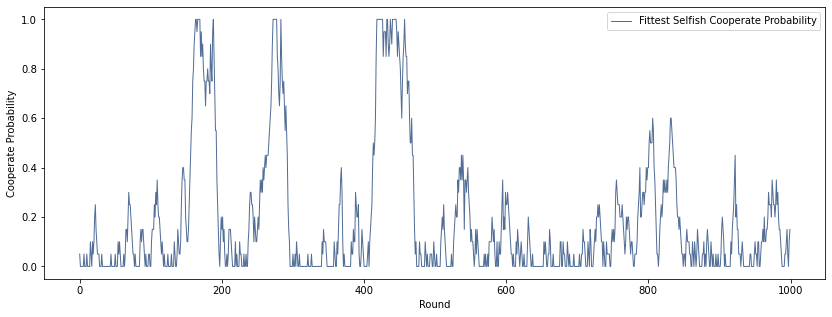

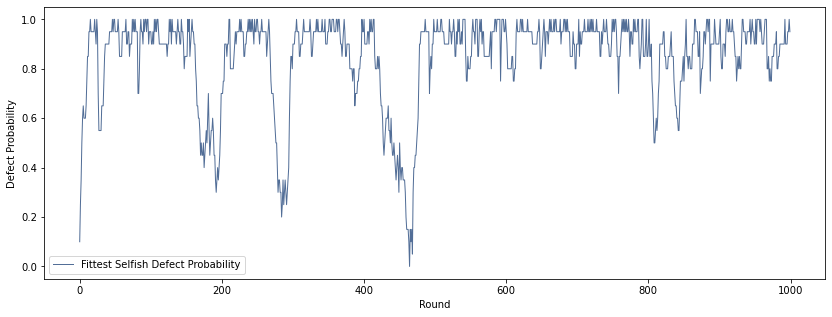

In [93]:
print("Selfish: ", selfishCount)
print("Generous: ", generousCount)
print("TitForTat: ", TFTCount)
print("The winner overall is person", people[fittestPersonIndex].identifier, "with", people[fittestPersonIndex].totalFitness, "points. Type:", people[fittestPersonIndex].type)
print("Winning strategy: {none:", people[fittestPersonIndex].strategy[None], ", C:", people[fittestPersonIndex].strategy["C"],
          ", D:", people[fittestPersonIndex].strategy["D"], "}", )
print("Average strategy: {none:", stratNone/len(people), ", C:", stratC/len(people),
          ", D:", stratD/len(people), "}", )


print("History elements for winner", people[fittestPersonIndex].identifier, ": ", len(people[fittestPersonIndex].nhist),len(people[fittestPersonIndex].chist), len(people[fittestPersonIndex].dhist))

averagedhist = []
averagechist = []
for i in range(0, len(people[0].dhist) - 1):
    avgd = 0
    avgc = 0
    for n in range(0, len(people) - 1):
        avgd += people[n].dhist[i]
        avgc += people[n].chist[i]
    averagedhist.append(avgd/len(people))
    averagechist.append(avgc/len(people))



thinkplot.figure(figsize=(14, 5))
#thinkplot.plot(people[fittestPersonIndex].chist, linestyle='solid', linewidth=1, label='Winner Cooperate Probability')
#thinkplot.plot(averagechist, linestyle='solid', linewidth=1, label='Average Cooperate Probability')
thinkplot.plot(people[fittestSelfish].chist, linestyle='solid', linewidth=1, label='Fittest Selfish Cooperate Probability')
#thinkplot.plot(people[fittestGenerous].chist, linestyle='solid', linewidth=1, label='Fittest Generous Cooperate Probability')
thinkplot.config(xlabel='Round', ylabel='Cooperate Probability')

thinkplot.figure(figsize=(14, 5))
#thinkplot.plot(people[fittestPersonIndex].dhist, linestyle='solid', linewidth=1, label='Winner Defect Probablity')
#thinkplot.plot(averagedhist, linestyle='solid', linewidth=1, label='Average Defect Probability')
thinkplot.plot(people[fittestSelfish].dhist, linestyle='solid', linewidth=1, label='Fittest Selfish Defect Probability')
#thinkplot.plot(people[fittestGenerous].dhist, linestyle='solid', linewidth=1, label='Fittest Generous Defect Probability')
thinkplot.config(xlabel='Round', ylabel='Defect Probability')
#stats.mean(people[:].dhist[3])


In [76]:
|

SyntaxError: invalid syntax (<ipython-input-76-4b37ef281455>, line 1)